<a href="https://colab.research.google.com/github/alihuss1017/LSTM-Weather-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
gh_token = userdata.get('GITHUB_TOKEN')

In [2]:
!git clone https://{gh_token}@github.com/alihuss1017/LSTM-Weather-Prediction.git

Cloning into 'LSTM-Weather-Prediction'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 4), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 19.06 KiB | 3.18 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
cd LSTM-Weather-Prediction

/content/LSTM-Weather-Prediction


In [4]:
import pandas as pd
df = pd.read_csv('data/seattle-weather.csv')

## Checking for Null Values and Duplicates

In [5]:
print(f'''Number of null values:\n{df.isnull().sum()}\n\nNumber of duplicated rows: {df.duplicated().sum()}''')

Number of null values:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

Number of duplicated rows: 0


## Setting DateTime as Index

In [6]:
df = df.set_index(df["date"])
df = df.drop('date', axis = 1)


## Saving the mean and standard deviation for Inference Purposes

In [7]:
mu, std = df['temp_max'].mean(), df['temp_max'].std()

## One-Hot Encoding Categorical Features:

In [8]:
df_encoded = pd.get_dummies(df, columns = ['weather'])

## Applying Z-Score Normalization on Numerical Features

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_normalize = df_encoded.select_dtypes(include='float').columns.tolist()

df_encoded[columns_to_normalize] = scaler.fit_transform(df_encoded[columns_to_normalize])

## Defining the PyTorch Custom Dataset Class

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class WeatherDataset(Dataset):

  def __init__(self, data_df, seq_len):
    self.data = data_df
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    cols_to_cast = self.data.select_dtypes(include = ['object', 'bool']).columns.tolist()
    for col in cols_to_cast:
      self.data[col] = self.data[col].astype('int')

    x = torch.tensor(self.data.iloc[idx:idx+self.seq_len].values, dtype = torch.float32)
    y = torch.tensor(self.data['temp_max'].iloc[idx+self.seq_len+1], dtype = torch.float32)

    return x, y


## Performing Train/Validation Split and Initializing DataLoaders

In [12]:
from torch.utils.data import Subset

seq_len = 5

dataset = WeatherDataset(data_df = df_encoded, seq_len = seq_len)
train_len = int(0.7 * len(dataset))

train_data = Subset(dataset, range(train_len))
val_data = Subset(dataset, range(train_len, len(dataset)))


train_loader = DataLoader(train_data, batch_size = 32, num_workers = 2, drop_last = True)
val_loader = DataLoader(val_data, batch_size = 32, num_workers = 2, drop_last = True )

## Defining Model

In [13]:
import torch.nn as nn

input_features = len(dataset[0][0][0])
hidden_features = 32
num_layers = 2

class lstmModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.lstm = nn.LSTM(input_size = input_features,
                        hidden_size = hidden_features, num_layers = num_layers,
                        batch_first = True)
    self.fc = nn.Linear(hidden_features, 1)

  def forward(self, x):
    out, [h, c] = self.lstm(x)
    return self.fc(h[-1])


## Model Debugging

In [14]:
model = lstmModel()
model.eval()
with torch.no_grad():
  print(f'Output: {model(torch.rand((seq_len, input_features)))}')

Output: tensor([0.0268])


## Defining Loss Criterion and Optimizer

In [15]:
import torch.optim as optim

lr = 0.001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

## Configuring Device

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f'Device: {device}')

Device: cuda


## Training Model

In [19]:
num_epochs = 10

model.train()

for epoch in range(num_epochs):
  total_loss = 0

  for X, y in train_loader:
    optimizer.zero_grad()

    X, y = X.to(device), y.to(device)
    y_hat = model(X)

    loss = loss_fn(y, y_hat)
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}')


Epoch 1 Loss: 0.31618179621235015
Epoch 2 Loss: 0.3149156017649558
Epoch 3 Loss: 0.3137826914748838
Epoch 4 Loss: 0.3127195943267115
Epoch 5 Loss: 0.3117306922231951
Epoch 6 Loss: 0.310799335760455
Epoch 7 Loss: 0.3099140678682635
Epoch 8 Loss: 0.30906433419835183
Epoch 9 Loss: 0.3082412930746232
Epoch 10 Loss: 0.307437535255186


## Evaluating Model

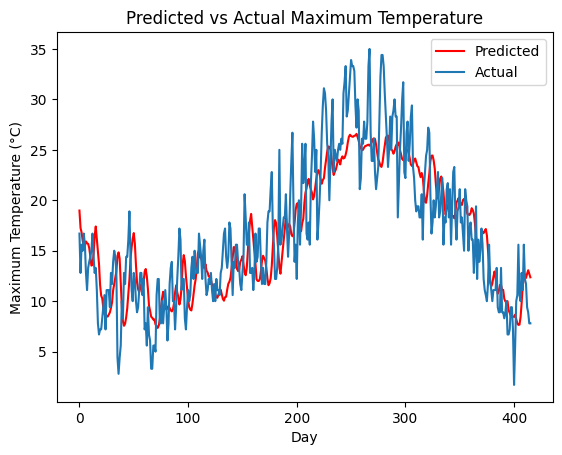

In [41]:
import matplotlib.pyplot as plt

predicted = []
actual = []

model.eval()

with torch.no_grad():
  for X, y in val_loader:
    X, y = X.to(device), y.to(device)
    y_hat = model(X)

    predicted.append(y_hat.cpu())
    actual.append(y.cpu())

plt.figure()
plt.title("Predicted vs Actual Maximum Temperature")
plt.xlabel("Day")
plt.ylabel("Maximum Temperature (°C)")
plt.plot(np.array(predicted).flatten() * std + mu, c = 'r', label = "Predicted")
plt.plot(np.array(actual).flatten() * std + mu, label = "Actual")
plt.legend()